# Four imputs (N,Z, uq, dq) and 1 outputs (Mass excess) in single ANN

# Imports

In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from utils import shuffle_batch, variable_summaries
import os

%matplotlib notebook

dir_path = os.getcwd()

now = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
print(dir_path)
print(now)

C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-4-inputs-mass-output
2019-08-20-15-09-54


In [2]:
#%matplotlib notebook

# Read the data set

In [3]:
df = pd.read_csv("better-nuclei-19-08.csv")
print(df.info())
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3436 entries, 0 to 3435
Data columns (total 10 columns):
Z                                  3436 non-null int64
N                                  3436 non-null int64
UQ                                 3436 non-null int64
DQ                                 3436 non-null int64
Mass Excess [MeV]                  3436 non-null float64
Mass Error                         3436 non-null float64
Mass Estimated                     3436 non-null int64
Neutron separation energy [MeV]    3318 non-null float64
Separation Error                   3318 non-null float64
Separation Estimated               3318 non-null float64
dtypes: float64(5), int64(5)
memory usage: 268.5 KB
None


Index(['Z', 'N', 'UQ', 'DQ', 'Mass Excess [MeV]', 'Mass Error',
       'Mass Estimated', 'Neutron separation energy [MeV]', 'Separation Error',
       'Separation Estimated'],
      dtype='object')

In [4]:
df = df.rename(columns=
               {"Mass Excess [MeV]": "d",
                "Z":'z',
                'N':'n',
                'UQ':"uq",
                'DQ':"dq",
                "Mass Error":"mass error",
                "Mass Estimated":"mass estimated",
                "Neutron separation energy [MeV]":"d2",
                "Separation Error":"separation error",
                "Separation Estimated":"separation estimated"               
               })
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3436 entries, 0 to 3435
Data columns (total 10 columns):
z                       3436 non-null int64
n                       3436 non-null int64
uq                      3436 non-null int64
dq                      3436 non-null int64
d                       3436 non-null float64
mass error              3436 non-null float64
mass estimated          3436 non-null int64
d2                      3318 non-null float64
separation error        3318 non-null float64
separation estimated    3318 non-null float64
dtypes: float64(5), int64(5)
memory usage: 268.5 KB
None


In [5]:
df.describe()

,z,n,uq,dq,d,mass error,mass estimated,d2,separation error,separation estimated
count,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3318.000000,3318.000000,3318.000000
mean,57.857392,82.034051,197.748836,221.925495,-24.144121,0.123589,0.272992,7.755557,0.164216,0.295660
std,27.809406,43.293558,98.188326,113.771063,56.200706,0.197548,0.445562,3.631747,0.254378,0.456408
min,0.000000,0.000000,1.000000,1.000000,-91.652853,0.000000,0.000000,-2.488000,0.000000,0.000000
25%,36.000000,47.000000,120.750000,131.000000,-65.400443,0.003006,0.000000,5.414787,0.005140,0.000000
50%,58.000000,81.000000,197.000000,219.000000,-39.335024,0.014474,0.000000,7.249960,0.025005,0.000000
75%,80.000000,114.000000,273.000000,308.000000,1.172301,0.196000,1.000000,9.654658,0.269058,1.000000
max,118.000000,177.000000,413.000000,472.000000,201.512000,2.003000,1.000000,27.715000,2.011000,1.000000


# Remove estimated Excess and estimated Seperation

In [6]:
not_estimated_filter = (df["mass estimated"] == 0)
df = df[not_estimated_filter]

not_estimated_filter = (df["separation estimated"] == 0)
df = df[not_estimated_filter]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 10 columns):
z                       2337 non-null int64
n                       2337 non-null int64
uq                      2337 non-null int64
dq                      2337 non-null int64
d                       2337 non-null float64
mass error              2337 non-null float64
mass estimated          2337 non-null int64
d2                      2337 non-null float64
separation error        2337 non-null float64
separation estimated    2337 non-null float64
dtypes: float64(5), int64(5)
memory usage: 200.8 KB


In [8]:
df.isnull().values.any()

False

In [9]:
df['z'].shape

(2337,)

In [10]:
df.count()

z                       2337
n                       2337
uq                      2337
dq                      2337
d                       2337
mass error              2337
mass estimated          2337
d2                      2337
separation error        2337
separation estimated    2337
dtype: int64

In [11]:
df.head()

,z,n,uq,dq,d,mass error,mass estimated,d2,separation error,separation estimated
0,0,1,1,2,8.071317,4.000000e-07,0,0.00000,0.00000,0.0
2,1,1,3,3,13.135722,1.000000e-07,0,2.22457,0.00000,0.0
3,1,2,4,5,14.949810,2.000000e-07,0,6.25723,0.00000,0.0
4,1,3,5,7,24.621127,1.000000e-01,0,-1.60000,0.10000,0.0
5,1,4,6,9,32.892444,8.944300e-02,0,-0.20000,0.13416,0.0


# Plot upper quarks column

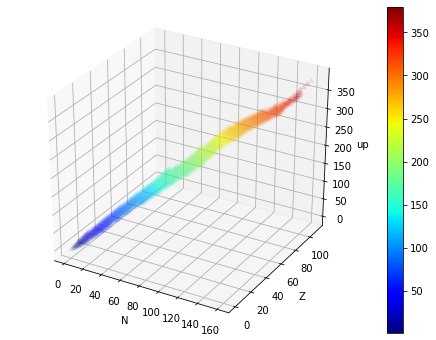

In [12]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = df['n']
ys = df['z']
zs = df['uq']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('up')


plt.show()

In [13]:
df['uq'].to_numpy().shape

(2337,)

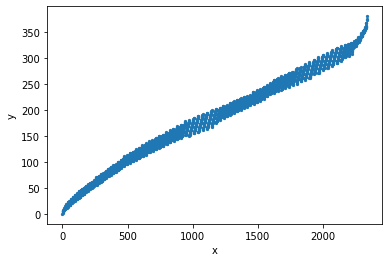

In [14]:
plt.scatter(range(df['uq'].count()), df['uq'].to_numpy(), s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Plot down quarks

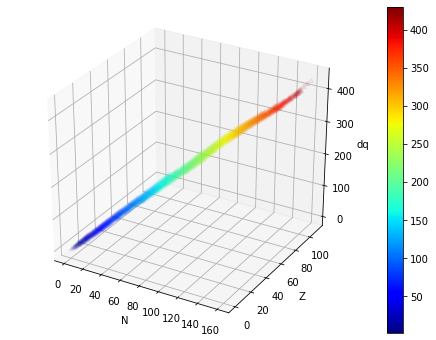

In [15]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = df['n']
ys = df['z']
zs = df['dq']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('dq')


plt.show()

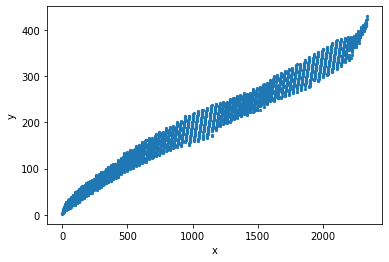

In [16]:
plt.scatter(range(df['dq'].count()), df['dq'].to_numpy(), s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Dividing Mass Excess by A = Z + N

In [17]:
zes = df['z'].to_numpy()
ns = df['n'].to_numpy()
a = zes + ns

des = df['d'].to_numpy() / a
df['d'] = des


# Plot Mass excess output column

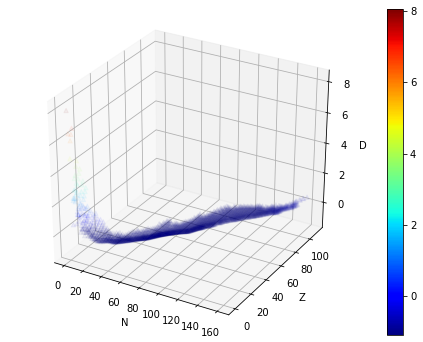

In [18]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = df['n']
ys = df['z']
zs = df['d']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

# Tripcolor

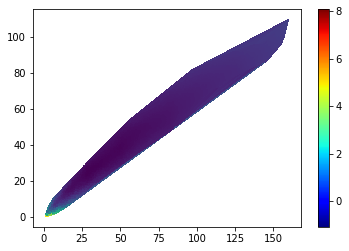

In [19]:
zs = df['d']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

#yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)


fig, (ax)=plt.subplots(ncols=1)
ax.tripcolor(df["n"], df["z"], df["d"])
cb = fig.colorbar(colmap)

plt.show()

# Set X inputs

In [20]:
x = df[['z','n','dq','uq']]
print(x.info())
x = x.to_numpy()
print(x.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 4 columns):
z     2337 non-null int64
n     2337 non-null int64
dq    2337 non-null int64
uq    2337 non-null int64
dtypes: int64(4)
memory usage: 91.3 KB
None
(2337, 4)


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 3369
Data columns (total 10 columns):
z                       2337 non-null int64
n                       2337 non-null int64
uq                      2337 non-null int64
dq                      2337 non-null int64
d                       2337 non-null float64
mass error              2337 non-null float64
mass estimated          2337 non-null int64
d2                      2337 non-null float64
separation error        2337 non-null float64
separation estimated    2337 non-null float64
dtypes: float64(5), int64(5)
memory usage: 200.8 KB


# Set Y inputs _(HERE CHANGE NUMBER OF INPUTS AND RESHAPE)

In [22]:
y = df[['d']].to_numpy() #HERE
y.shape

(2337, 1)

In [23]:
y = y.reshape(-1,1) #HERE
y.shape

(2337, 1)

In [24]:
y[0:5]

array([[8.07131713],
       [6.56786088],
       [4.98326998],
       [6.15528175],
       [6.5784888 ]])

# Prepare X_train_o, Y_train_o etc

In [25]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(x, y, test_size=0.2, random_state=1)
X_train_o, X_val_o, y_train_o, y_val_o  = train_test_split(X_train_o, y_train_o, test_size=0.2, random_state=1)
n_inputs = X_train_o.shape[1]
n_outputs = y_train_o.shape[1]
print(n_inputs)
print(n_outputs)
print(X_train_o.shape, X_test_o.shape,X_val_o.shape)

4
1
(1495, 4) (468, 4) (374, 4)


# Scaling

In [26]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train_o.reshape(-1, n_inputs))
X_test = x_scaler.transform(X_test_o.reshape(-1, n_inputs))
X_val = x_scaler.transform(X_val_o.reshape(-1, n_inputs))

y_train = y_scaler.fit_transform(y_train_o.reshape(-1, n_outputs))
y_test = y_scaler.transform(y_test_o.reshape(-1, n_outputs))
y_val = y_scaler.transform(y_val_o.reshape(-1, n_outputs))

n_inputs = X_train.shape[1]
n_outputs = y_train.shape[1]
print(n_inputs)
print(n_outputs)

4
1


# ANN TOPOLOGY

In [27]:
def cust_layer(inputs,number_of_neurons, name, activation=None, dropout=False):
    init = tf.initializers.he_normal(seed=None)
    hidden = tf.keras.layers.Dense(number_of_neurons,
                                   name=name,
                                    kernel_initializer=init,
                                   activation = activation,
                                   kernel_regularizer = tf.keras.regularizers.l2(l=0.1)
                                  )(inputs)
    
    batch_norm = tf.keras.layers.BatchNormalization()(hidden, training=True)
    
    if dropout:
        dropout_layer = tf.keras.layers.Dropout(0.5)(batch_norm)
        return dropout_layer
    else:
        return batch_norm
    
tf.reset_default_graph()
with tf.name_scope("dnn"):
    with tf.name_scope("inputs"):
        X_node = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y_node = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y")
    
    last_layer = cust_layer(X_node,50,"hidden1")    
    n_layers = 10
    
    for i in range(n_layers):      
            
        last_layer = cust_layer(last_layer,150,"hidden"+str(i),activation=tf.nn.elu,dropout=True)
    last_layer = cust_layer(last_layer,50,"hidden"+str(i+1),activation=tf.nn.elu,dropout=True)
    
    init = tf.initializers.he_normal()    
    y_pred = tf.keras.layers.Dense(n_outputs, name="output",kernel_initializer=init)(last_layer)

    
with tf.name_scope('MSE'):
    error_f = y_pred - y_node
    square_f = tf.square(error_f)
    mse = tf.reduce_mean(square_f, name="mse_first")
    variable_summaries(mse)
    print(error_f.get_shape())


with tf.name_scope('optimiser'):
    optimiser = tf.train.AdamOptimizer(0.01)
    training_op = optimiser.minimize(mse)

for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)

W0820 15:09:58.390559 24028 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-4-inputs-mass-output\utils.py:16: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0820 15:09:58.403526 24028 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\nuclei\nuclei-updated-4-inputs-mass-output\utils.py:22: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.



(?, 1)


# File writers

In [28]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
test_writer = tf.summary.FileWriter(logdir + '/test')
valid_writer = tf.summary.FileWriter(logdir + '/valid')
init = tf.global_variables_initializer()

saver = tf.train.Saver()

checkpoint_path = os.path.join(dir_path, "sinus_tmp","sinus_full_model.ckpt")
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = os.path.join(dir_path, "model", "my_sinus_full_model")

# Number of epochs and batches

In [29]:
n_epochs = 2000
n_batches = 50

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = n_epochs * 0.2
print(max_epochs_without_progress)



400.0


# Training

In [30]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, n_batches):
            summary, _ = sess.run([merged, training_op],
                                  feed_dict={X_node: X_batch, y_node: y_batch})

        train_summary, _ = sess.run([merged, training_op],feed_dict={X_node: X_train, y_node: y_train})
        test_summary, _ =sess.run([merged, training_op],feed_dict={X_node: X_test, y_node: y_test})
        validation_summary, _ = sess.run([merged, training_op], feed_dict={X_node: X_val, y_node: y_val})

        train_writer.add_summary(train_summary, epoch)
        test_writer.add_summary(test_summary, epoch)
        valid_writer.add_summary(validation_summary,epoch)

        loss_train = mse.eval(feed_dict={X_node: X_train, y_node: y_train})
        loss_val = mse.eval(feed_dict={X_node: X_val, y_node: y_val})
        print(epoch, "train loss:", loss_train, "valid loss:", loss_val)

        iteration_skip = 10
        if epoch % iteration_skip == 0:
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

        if loss_val < best_loss:
            saver.save(sess, final_model_path)
            best_loss = loss_val
            print("best loss:", best_loss)
            epochs_without_progress = 0
        else:
            epochs_without_progress += 1
            if epochs_without_progress > max_epochs_without_progress:
                print("Early stopping")
                break


train_writer.close()
test_writer.close()
valid_writer.close()

0 train loss: 0.1884652 valid loss: 0.27415377
best loss: 0.27415377
1 train loss: 0.126547 valid loss: 0.21128482
best loss: 0.21128482
2 train loss: 0.2153945 valid loss: 0.34169835
3 train loss: 0.23598795 valid loss: 0.38241193
4 train loss: 0.08159679 valid loss: 0.16696051
best loss: 0.16696051
5 train loss: 0.1700338 valid loss: 0.24761763
6 train loss: 0.12045347 valid loss: 0.18293786
7 train loss: 0.16591118 valid loss: 0.25581983
8 train loss: 0.13850757 valid loss: 0.14876844
best loss: 0.14876844
9 train loss: 0.103949465 valid loss: 0.15365973
10 train loss: 0.11515224 valid loss: 0.16989948
11 train loss: 0.14307357 valid loss: 0.21467644
12 train loss: 0.093216635 valid loss: 0.14835449
best loss: 0.14835449
13 train loss: 0.11301655 valid loss: 0.18987158
14 train loss: 0.12883517 valid loss: 0.2308014
15 train loss: 0.1082148 valid loss: 0.16984399
16 train loss: 0.13317302 valid loss: 0.23856963
17 train loss: 0.11999964 valid loss: 0.20467399
18 train loss: 0.085980

162 train loss: 0.08732945 valid loss: 0.16857451
163 train loss: 0.07754921 valid loss: 0.15180111
164 train loss: 0.100974396 valid loss: 0.20005994
165 train loss: 0.06400305 valid loss: 0.12658787
166 train loss: 0.06405713 valid loss: 0.11957453
167 train loss: 0.12416614 valid loss: 0.21639411
168 train loss: 0.09841746 valid loss: 0.18560237
169 train loss: 0.101364225 valid loss: 0.21840398
170 train loss: 0.123243384 valid loss: 0.24242383
171 train loss: 0.092534676 valid loss: 0.20639095
172 train loss: 0.066894785 valid loss: 0.1424603
173 train loss: 0.10743502 valid loss: 0.20975898
174 train loss: 0.07450975 valid loss: 0.17020215
175 train loss: 0.06948464 valid loss: 0.16170622
176 train loss: 0.09930251 valid loss: 0.18347399
177 train loss: 0.078716844 valid loss: 0.16625054
178 train loss: 0.105941534 valid loss: 0.19535783
179 train loss: 0.07180836 valid loss: 0.16277392
180 train loss: 0.06737421 valid loss: 0.14500839
181 train loss: 0.082621686 valid loss: 0.16

326 train loss: 0.07284359 valid loss: 0.15990108
327 train loss: 0.06714861 valid loss: 0.15317512
328 train loss: 0.04492997 valid loss: 0.105203465
329 train loss: 0.083913535 valid loss: 0.18077144
330 train loss: 0.108368695 valid loss: 0.2080797
331 train loss: 0.06373236 valid loss: 0.13770574
332 train loss: 0.05287986 valid loss: 0.1230518
333 train loss: 0.08052193 valid loss: 0.15566327
334 train loss: 0.083351925 valid loss: 0.15347448
335 train loss: 0.049644377 valid loss: 0.10097676
336 train loss: 0.062701516 valid loss: 0.14302462
337 train loss: 0.061826225 valid loss: 0.1155529
338 train loss: 0.08367665 valid loss: 0.17244792
339 train loss: 0.08654279 valid loss: 0.17759798
340 train loss: 0.12256441 valid loss: 0.2306593
341 train loss: 0.068108484 valid loss: 0.14537828
342 train loss: 0.07021926 valid loss: 0.1535722
343 train loss: 0.047904238 valid loss: 0.10637684
344 train loss: 0.05938802 valid loss: 0.13189231
345 train loss: 0.08924043 valid loss: 0.18103

489 train loss: 0.06261365 valid loss: 0.14192437
490 train loss: 0.07304615 valid loss: 0.15050809
491 train loss: 0.07229284 valid loss: 0.16671717
492 train loss: 0.07865243 valid loss: 0.15918247
493 train loss: 0.07706878 valid loss: 0.16932021
494 train loss: 0.056606814 valid loss: 0.13021933
495 train loss: 0.04401672 valid loss: 0.1099004
496 train loss: 0.06894727 valid loss: 0.14598177
497 train loss: 0.072124936 valid loss: 0.1581885
498 train loss: 0.07286711 valid loss: 0.16198154
499 train loss: 0.098950274 valid loss: 0.20306984
500 train loss: 0.05205663 valid loss: 0.12443802
501 train loss: 0.11606715 valid loss: 0.21641633
502 train loss: 0.059174094 valid loss: 0.12929986
503 train loss: 0.05277719 valid loss: 0.12630604
504 train loss: 0.04851133 valid loss: 0.111059405
505 train loss: 0.061198328 valid loss: 0.14367862
506 train loss: 0.049592406 valid loss: 0.12416607
507 train loss: 0.057005286 valid loss: 0.13656664
508 train loss: 0.06394102 valid loss: 0.139

652 train loss: 0.087236404 valid loss: 0.17650416
653 train loss: 0.07712004 valid loss: 0.1595043
654 train loss: 0.06668608 valid loss: 0.118746586
655 train loss: 0.06098764 valid loss: 0.104002886
656 train loss: 0.07089471 valid loss: 0.15894371
657 train loss: 0.101669036 valid loss: 0.16335958
658 train loss: 0.05853749 valid loss: 0.10895176
659 train loss: 0.05120207 valid loss: 0.13100158
660 train loss: 0.050069064 valid loss: 0.12834093
661 train loss: 0.05725367 valid loss: 0.14042039
662 train loss: 0.04756828 valid loss: 0.113790005
663 train loss: 0.052489985 valid loss: 0.124173425
664 train loss: 0.04073555 valid loss: 0.10842544
665 train loss: 0.049712013 valid loss: 0.11629865
666 train loss: 0.05433684 valid loss: 0.1301234
667 train loss: 0.040898018 valid loss: 0.11058586
668 train loss: 0.051751066 valid loss: 0.1324483
669 train loss: 0.061373916 valid loss: 0.13888742
670 train loss: 0.06313921 valid loss: 0.1169859
671 train loss: 0.070484884 valid loss: 0.

814 train loss: 0.04021478 valid loss: 0.10128804
815 train loss: 0.03520336 valid loss: 0.092866234
816 train loss: 0.030441836 valid loss: 0.08301626
817 train loss: 0.040472884 valid loss: 0.0802276
818 train loss: 0.0496296 valid loss: 0.114426404
819 train loss: 0.04979216 valid loss: 0.12507185
820 train loss: 0.05058531 valid loss: 0.10751357
821 train loss: 0.04827136 valid loss: 0.11864612
822 train loss: 0.05034883 valid loss: 0.11840709
823 train loss: 0.04242683 valid loss: 0.11053948
824 train loss: 0.04437093 valid loss: 0.11601636
825 train loss: 0.049262274 valid loss: 0.11863292
826 train loss: 0.040471796 valid loss: 0.100042075
827 train loss: 0.040880516 valid loss: 0.099856615
828 train loss: 0.02653657 valid loss: 0.07216617
829 train loss: 0.033844784 valid loss: 0.09513012
830 train loss: 0.05733982 valid loss: 0.12097583
831 train loss: 0.039828654 valid loss: 0.10462288
832 train loss: 0.045151968 valid loss: 0.1141679
833 train loss: 0.040787864 valid loss: 0

977 train loss: 0.058674496 valid loss: 0.1337619
978 train loss: 0.054562736 valid loss: 0.11803334
979 train loss: 0.046741158 valid loss: 0.12044118
980 train loss: 0.038861003 valid loss: 0.08717904
981 train loss: 0.044051692 valid loss: 0.11008829
982 train loss: 0.055222735 valid loss: 0.11542448
983 train loss: 0.045341026 valid loss: 0.11216434
984 train loss: 0.052420232 valid loss: 0.12437052
985 train loss: 0.04994564 valid loss: 0.12314965
986 train loss: 0.061301567 valid loss: 0.14135686
987 train loss: 0.041372262 valid loss: 0.10910077
988 train loss: 0.049839858 valid loss: 0.12062261
989 train loss: 0.15317892 valid loss: 0.2799822
990 train loss: 0.07813889 valid loss: 0.12974547
991 train loss: 0.07681384 valid loss: 0.13131377
992 train loss: 0.058578108 valid loss: 0.14798833
993 train loss: 0.055033598 valid loss: 0.119539686
994 train loss: 0.059206 valid loss: 0.13102113
995 train loss: 0.07589193 valid loss: 0.16089897
996 train loss: 0.055160705 valid loss: 

1137 train loss: 0.035798613 valid loss: 0.090467155
1138 train loss: 0.026702126 valid loss: 0.08307312
1139 train loss: 0.050622582 valid loss: 0.10933436
1140 train loss: 0.041997094 valid loss: 0.10752477
1141 train loss: 0.048740365 valid loss: 0.10587922
1142 train loss: 0.04535776 valid loss: 0.10435793
1143 train loss: 0.056394555 valid loss: 0.12874763
1144 train loss: 0.059416633 valid loss: 0.1092409
1145 train loss: 0.058677893 valid loss: 0.08849589
1146 train loss: 0.07846644 valid loss: 0.16375093
1147 train loss: 0.06706834 valid loss: 0.14654915
1148 train loss: 0.03521543 valid loss: 0.08939093
1149 train loss: 0.067256905 valid loss: 0.15287828
1150 train loss: 0.052796885 valid loss: 0.13167603
1151 train loss: 0.05553279 valid loss: 0.12560734
1152 train loss: 0.03458336 valid loss: 0.094193436
1153 train loss: 0.032489717 valid loss: 0.09235092
1154 train loss: 0.024343846 valid loss: 0.07574722
1155 train loss: 0.0367928 valid loss: 0.09192409
1156 train loss: 0.

In [31]:
os.remove(checkpoint_epoch_path)

# Predictions

In [32]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    test_mse = mse.eval(feed_dict={X_node: X_test, y_node: y_test})
    predictions = y_pred.eval(feed_dict={X_node: X_test, y_node: y_test})
    
    
print(test_mse)

W0820 15:21:49.747424 24028 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.19529067


In [33]:
predictions.shape

(468, 1)

# Plot  _first (0th)_ output column of _predictions_

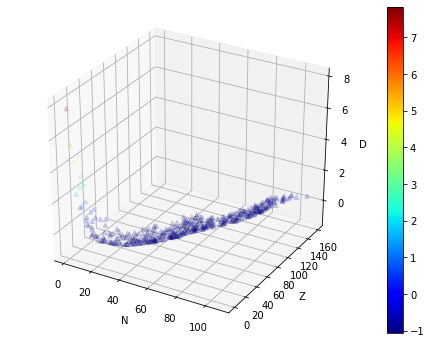

In [34]:
y_new_inverse = y_scaler.inverse_transform(predictions)
x_test_inverse = x_scaler.inverse_transform(X_test)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = y_new_inverse[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

In [35]:
y_test_o.shape[0]


468

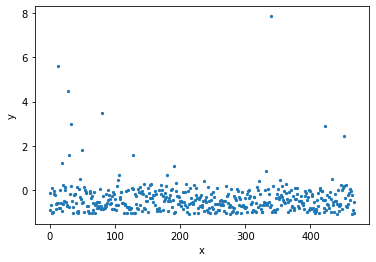

In [36]:
plt.scatter(range(y_new_inverse.shape[0]), y_new_inverse[:,0], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Plot _first 0th_ column of TEST set

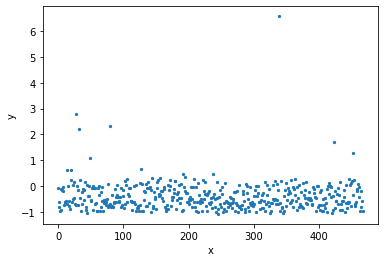

In [37]:
plt.scatter(range(y_test_o.shape[0]), y_test_o, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

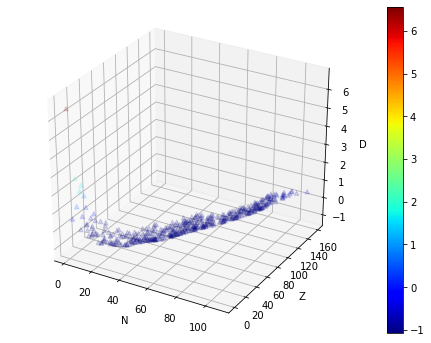

In [38]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = X_test_o[:,0]
ys = X_test_o[:,1]
zs = y_test_o[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

# Calculate _diff_ and _diff_abs_ (no distinction for columns)

In [39]:
#diff = np.square((y_new_inverse - y_test_o) / y_test_o)
substraction = y_new_inverse - y_test_o
diff = np.divide( substraction , y_test_o, out = substraction, where = y_test_o != 0)
diff_abs = y_new_inverse - y_test_o

In [40]:
print(diff.shape)
print(diff_abs.shape)

(468, 1)
(468, 1)


In [41]:
diff_df = pd.DataFrame(data={
                            'rel diff mass': diff[:,0],                            
                            'abs diff mass' : diff_abs[:,0]                             
                            })
diff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 2 columns):
rel diff mass    468 non-null float64
abs diff mass    468 non-null float64
dtypes: float64(2)
memory usage: 7.4 KB


# Replace inf and -inf with Nan, then drop the nans

In [42]:
diff_df = diff_df.replace([np.inf, -np.inf], np.nan)

In [43]:
print(diff_df.isnull().values.any())
print(diff_df.isnull().sum())
diff_df = diff_df.dropna()

False
rel diff mass    0
abs diff mass    0
dtype: int64


In [44]:
diff_df.describe()

,rel diff mass,abs diff mass
count,468.000000,468.000000
mean,0.264491,0.037392
std,3.242786,0.300519
min,-7.046741,-0.100234
25%,-0.040393,-0.031956
50%,0.032672,-0.014069
75%,0.084792,0.003313
max,59.947451,5.001624


# Plot the relative diff of the first column

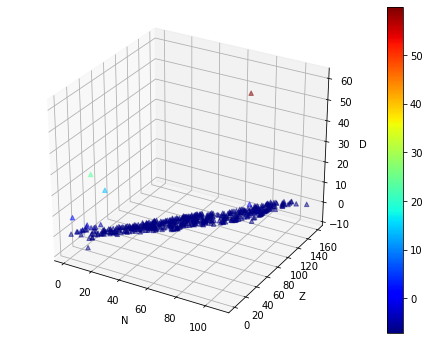

In [45]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = diff_df['rel diff mass']# diff[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.5)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

In [46]:
#%matplotlib notebook

In [47]:
vals = diff_df['rel diff mass'].to_numpy()
print(vals.shape)
print(vals.shape[0])

(468,)
468


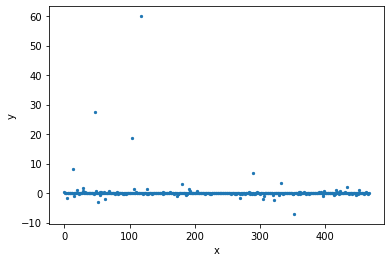

In [48]:
#plt.scatter(iterate_x, diff[:,0], s=5)

plt.scatter(range(vals.shape[0]),vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

# Diff ABSOLUTE of first column

In [49]:
vals = diff_df['abs diff mass'].to_numpy()
print(vals.shape)
range_x = range(vals.shape[0])

(468,)


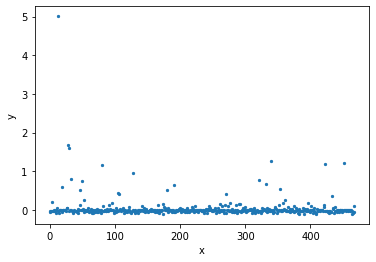

In [50]:
plt.scatter(range_x,vals, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()